# Multiclass Voting Classifier to Predict Wine Quality Score

## Wine Data
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citations
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml/index.php](http://archive.ics.uci.edu/ml/index.php). Irvine, CA: University of California, School of Information and Computer Science.
## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

red_wine = pd.read_csv('../../ch_10/data/winequality-red.csv')
white_wine = pd.read_csv('../../ch_10/data/winequality-white.csv', sep=';')

## EDA

In [2]:
wine = pd.concat([white_wine.assign(kind='white'), red_wine.assign(kind='red')])
wine.sample(5, random_state=10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kind
848,6.4,0.64,0.21,1.8,0.081,14.0,31.0,0.99689,3.59,0.66,9.8,5,red
2529,6.6,0.42,0.13,12.8,0.044,26.0,158.0,0.99772,3.24,0.47,9.0,5,white
131,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5,red
244,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,red
1551,6.6,0.19,0.99,1.2,0.122,45.0,129.0,0.99360,3.09,0.31,8.7,6,white


<AxesSubplot:title={'center':'Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

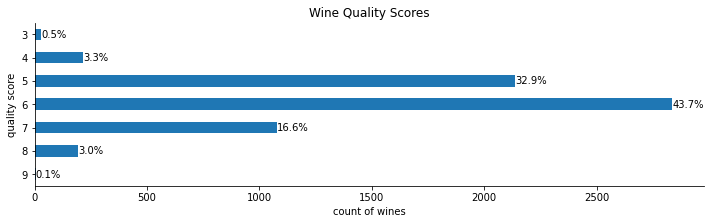

In [3]:
def plot_quality_scores(df):
    ax = df.quality.value_counts().sort_index(
        ascending=False
    ).plot.barh(title='Wine Quality Scores', figsize=(12, 3))
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/4, 
            f'{bar.get_width()/df.shape[0]:.1%}'
        )
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    
    return ax

plot_quality_scores(wine)

In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  kind                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 710.6+ KB


In [5]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
wine.kind.value_counts()

white    4898
red      1599
Name: kind, dtype: int64

## Train test split

In [7]:
from sklearn.model_selection import train_test_split

wine_y = wine.pop('quality')
wine_X = wine

X_train, X_test, y_train, y_test = train_test_split(
    wine_X, wine_y, test_size=0.25, random_state=0, stratify=wine_y
)

X_train.sample(5, random_state=0)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,kind
987,7.1,0.36,0.30,1.6,0.080,35.0,70.0,0.99693,3.44,0.50,9.4,red
1219,8.2,0.37,0.36,1.0,0.034,17.0,93.0,0.99060,3.04,0.32,11.7,white
2380,6.4,0.27,0.19,1.9,0.085,21.0,196.0,0.99516,3.49,0.64,9.5,white
2770,6.4,0.44,0.44,14.4,0.048,29.0,228.0,0.99955,3.26,0.54,8.8,white
857,8.2,0.40,0.48,13.7,0.042,59.0,169.0,0.99860,3.10,0.52,9.4,white


## Build models
### Random Forest

In [8]:
%%capture
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

pipeline = Pipeline([
    ('transformer', ColumnTransformer([
        ('scale', StandardScaler(), slice(0, -1)),
        ('encode', OneHotEncoder(sparse=False), [-1])
    ])),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=0))
])

search_space = {
    'rf__max_depth': np.arange(5, 20, 5)
}

rf = GridSearchCV(pipeline, search_space, scoring='f1_macro', cv=5).fit(X_train, y_train)

### Gradient Boosted Trees

In [9]:
%%capture
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

pipeline = Pipeline([
    ('transformer', ColumnTransformer([
        ('scale', StandardScaler(), slice(0, -1)),
        ('encode', OneHotEncoder(sparse=False), [-1])
    ])),
    ('gb', GradientBoostingClassifier(random_state=0))
])

search_space = {
    'gb__max_depth': np.arange(3, 12, 3)
}

gb = GridSearchCV(pipeline, search_space, scoring='f1_macro', cv=5).fit(X_train, y_train)

### k-NN

In [10]:
%%capture
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

pipeline = Pipeline([
    ('transformer', ColumnTransformer([
        ('scale', StandardScaler(), slice(0, -1)),
        ('encode', OneHotEncoder(sparse=False), [-1])
    ])),
    ('knn', KNeighborsClassifier())
])

search_space = {
    'knn__n_neighbors': np.arange(1, 5)
}

knn = GridSearchCV(pipeline, search_space, scoring='f1_macro', cv=5).fit(X_train, y_train)

### Logistic Regression

In [11]:
%%capture
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

pipeline = Pipeline([
    ('transformer', ColumnTransformer([
        ('scale', StandardScaler(), slice(0, -1)),
        ('encode', OneHotEncoder(sparse=False), [-1])
    ])),
    ('lr', LogisticRegression(random_state=0, multi_class='multinomial'))
])

search_space = {
    'lr__C': [0.1, 0.5, 1, 5]
}

lr = GridSearchCV(pipeline, search_space, scoring='f1_macro', cv=5).fit(X_train, y_train)

### Naive Bayes

In [12]:
%%capture
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

nb = Pipeline([
    ('transformer', ColumnTransformer([
        ('scale', StandardScaler(), slice(0, -1)),
        ('encode', OneHotEncoder(sparse=False), [-1])
    ])),
    ('nb', GaussianNB())
]).fit(X_train, y_train)

### Determine agreement between the models with Cohen's Kappa

In [13]:
import itertools
from sklearn.metrics import cohen_kappa_score

models = zip(
    ['random forest', 'gradient boosting', 'knn', 'logistic regression', 'naive bayes'], 
    [rf, gb, knn, lr, nb]
)

def get_preds(model, test_X_data):
    return model.predict(test_X_data)

for ((model_1_name, model_1), (model_2_name, model_2)) in itertools.combinations(models, 2):
    score = cohen_kappa_score(*map(get_preds, [model_1, model_2], itertools.repeat(X_test)))
    print(f"Cohen's Kappa between {model_1_name} and {model_2_name} is: {score:.2f}")

Cohen's Kappa between random forest and gradient boosting is: 0.78
Cohen's Kappa between random forest and knn is: 0.55
Cohen's Kappa between random forest and logistic regression is: 0.51
Cohen's Kappa between random forest and naive bayes is: 0.13
Cohen's Kappa between gradient boosting and knn is: 0.55
Cohen's Kappa between gradient boosting and logistic regression is: 0.45
Cohen's Kappa between gradient boosting and naive bayes is: 0.13
Cohen's Kappa between knn and logistic regression is: 0.24
Cohen's Kappa between knn and naive bayes is: 0.09
Cohen's Kappa between logistic regression and naive bayes is: 0.19


## Voting Classifier with Majority Rules

In [14]:
%%capture
from sklearn.ensemble import VotingClassifier

majority_rules = VotingClassifier(
    [('rf', rf.best_estimator_), ('gb', gb.best_estimator_), 
     ('knn', knn.best_estimator_), ('lr', lr.best_estimator_),
     ('nb', nb)],
    voting='hard',
    weights=[1, 1, 1, 1, .5]
).fit(X_train, y_train)

### Evaluate model

In [15]:
majority_rules.score(X_test, y_test)

0.6658461538461539

Get predictions:

In [16]:
preds = majority_rules.predict(X_test)

Examine the classification report:

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.70      0.13      0.22        54
           5       0.70      0.70      0.70       535
           6       0.62      0.78      0.69       709
           7       0.74      0.46      0.57       270
           8       0.90      0.38      0.53        48
           9       0.00      0.00      0.00         1

    accuracy                           0.67      1625
   macro avg       0.52      0.35      0.39      1625
weighted avg       0.68      0.67      0.65      1625



/home/stefaniemolin/book_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Look at the confusion matrix:

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

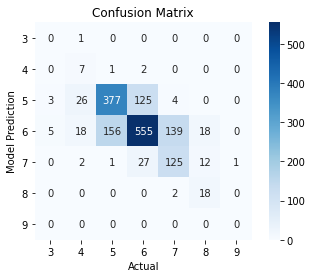

In [18]:
from ml_utils.classification import confusion_matrix_visual

confusion_matrix_visual(y_test, preds, np.sort(wine_y.unique()))